## Basic configuration

In [2]:
# Define Configuration
import os, io, json, time, re, boto3, sagemaker
import pandas as pd

from sagemaker import get_execution_role
from botocore.exceptions import ClientError

sess   = sagemaker.Session()
sm     = sess.sagemaker_client
s3c    = boto3.client("s3")
region = boto3.session.Session().region_name
role   = get_execution_role()

# Project names / resources
BUCKET  = sess.default_bucket()                      # studio default (good for classwork)
PREFIX  = "ai4i"                                    # everything lives under s3://BUCKET/ai4i/

# Define S3 paths
# Note: S3 paths must end with a slash ("/") to be valid in SageMaker
#       (this is not enforced by the S3 API, but by SageMaker)
def _slash(p): 
    return p if p.endswith("/") else p + "/"

# Canonical S3 layout
RAW_S3           = f"s3://{BUCKET}/{PREFIX}/raw/"
PROC_S3          = f"s3://{BUCKET}/{PREFIX}/processed/"
TRAIN_S3         = _slash(PROC_S3 + "train")
VAL_S3           = _slash(PROC_S3 + "val")
TEST_S3          = _slash(PROC_S3 + "test")
MODELS_S3_BASE   = f"s3://{BUCKET}/{PREFIX}/models/"
EVAL_S3_BASE     = f"s3://{BUCKET}/{PREFIX}/evaluation/"
MODEL_GROUP      = "ai4i-predictive-maintenance"     # Model Registry group
ENDPOINT_NAME    = "ai4i-staging"
ENDPOINT_INSTANCE= "ml.m5.large"                     # stable & quota-friendly
SKLEARN_VERSION  = "1.2-1"                           # <-- keep training & serving consistent
TARGET           = "Machine failure"                 # label column name (space deliberate)

print("Region:", region)
print("Role:", role)
print("S3 base:", f"s3://{BUCKET}/{PREFIX}")
print("Endpoint name:", ENDPOINT_NAME)
print("Model Group:", MODEL_GROUP)
print("Endpoint instance type:", ENDPOINT_INSTANCE) 

# ---- Aliases to keep older cells working (do not edit) ----
# PROCESSED_PREFIX = PROC_S3
# MODELS_S3        = MODELS_S3_BASE
# EVAL_S3          = EVAL_S3_BASE


Region: ap-southeast-1
Role: arn:aws:iam::837028399719:role/iti113-team16-sagemaker-iti113-team16-domain-iti113-team16-Role
S3 base: s3://sagemaker-ap-southeast-1-837028399719/ai4i
Endpoint name: ai4i-staging
Model Group: ai4i-predictive-maintenance
Endpoint instance type: ml.m5.large


## 1) Save robust inference.py (JSON and CSV; auto column alignment)

In [2]:
# Write robust inference.py (serves JSON & CSV, aligns columns)
code = r'''
import os, io, json, joblib, numpy as np, pandas as pd

# Define model directory (default for SageMaker)
# Note: this is where SageMaker will save the model artifacts
MODEL_DIR = os.environ.get("SM_MODEL_DIR", "/opt/ml/model")

# Load model and expected feature names
# (if available, e.g., from a preprocessing step)
def _load_model_and_expected():
    pipe = joblib.load(os.path.join(MODEL_DIR, "model.joblib"))
    expected = []
    try:
        pre = getattr(pipe, "named_steps", {}).get("preprocess")
        if pre is not None and hasattr(pre, "feature_names_in_"):
            expected = list(pre.feature_names_in_)
    except Exception:
        pass
    return pipe, expected

# Load the model and expected feature names
# (this is done once when the container starts)
PIPE, EXPECTED = _load_model_and_expected()

# Input function to parse incoming requests
# (supports JSON and CSV formats)
def input_fn(request_body, content_type):
    import io, json, pandas as pd, numpy as np
    if content_type.startswith("application/json"):
        obj = json.loads(request_body)
        if isinstance(obj, dict) and "instances" in obj:
            df = pd.DataFrame(obj["instances"])
        elif isinstance(obj, list):
            df = pd.DataFrame(obj)
        elif isinstance(obj, dict):
            df = pd.DataFrame([obj])
        else:
            raise ValueError("Unsupported JSON payload.")
    elif content_type.startswith("text/csv"):
        df = pd.read_csv(io.StringIO(request_body), header=None)
        if EXPECTED:
            df.columns = EXPECTED
    else:
        raise ValueError(f"Unsupported Content-Type: {content_type}")

    if EXPECTED:
        for c in EXPECTED:
            if c not in df.columns:
                df[c] = np.nan
        df = df[EXPECTED]

    # light dtype hygiene for obvious booleans
    for c in df.columns:
        if df[c].dtype == object:
            vals = set(df[c].dropna().astype(str).str.lower())
            if vals <= {"true","false"}:
                df[c] = df[c].map(lambda x: str(x).lower()=="true" if pd.notna(x) else x)
    return df


# Prediction function to make predictions using the loaded model
# (handles both classification and regression)
def predict_fn(input_data, model):
    try:
        proba = model.predict_proba(input_data)[:, 1]
        return {"prob": proba}
    except Exception:
        pred = model.predict(input_data)
        return {"label": pred}

# Output function to format the prediction results
# (returns JSON with predictions)
def output_fn(prediction, accept):
    import json
    payload = prediction.get("prob", prediction.get("label"))
    return json.dumps({"predictions": (payload.tolist() if hasattr(payload, "tolist") else payload)}), "application/json"
'''
open("inference.py", "w").write(code)
print("Wrote inference.py")


Wrote inference.py


## 2) Create evaluate_sklearn.py

In [12]:
# Write evaluate_sklearn.py
code = r'''
# evaluate_sklearn.py
import os, json, tarfile, joblib, pandas as pd, numpy as np
from glob import glob
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, fbeta_score

# Constants (SageMaker Processing mount points)
MODEL_DIR = "/opt/ml/processing/model"
TEST_DIR  = "/opt/ml/processing/test"
OUT_DIR   = "/opt/ml/processing/evaluation"
TARGET    = "Machine failure"         # your label name
THRESHOLD = 0.5                       # decision threshold for precision/recall/F2

os.makedirs(OUT_DIR, exist_ok=True)

def _debug_ls():
    try:
        print("[debug] MODEL_DIR:", os.listdir(MODEL_DIR))
    except Exception as e:
        print("[debug] MODEL_DIR ls error:", e)
    try:
        print("[debug] TEST_DIR:", os.listdir(TEST_DIR))
    except Exception as e:
        print("[debug] TEST_DIR ls error:", e)

# Ensure model.joblib is present; if not, extract model.tar.gz
_debug_ls()
model_path = os.path.join(MODEL_DIR, "model.joblib")
tar_path   = os.path.join(MODEL_DIR, "model.tar.gz")
if not os.path.exists(model_path):
    if os.path.exists(tar_path):
        print("[info] model.joblib not found; extracting model.tar.gz …")
        with tarfile.open(tar_path, "r:gz") as t:
            t.extractall(MODEL_DIR)
        _debug_ls()
    else:
        raise FileNotFoundError(
            f"Neither {model_path} nor {tar_path} found. "
            "Confirm your ProcessingInput(source=<s3 model.tar.gz>, destination=/opt/ml/processing/model)."
        )

if not os.path.exists(model_path):
    raise FileNotFoundError(f"After extraction, {model_path} still not found.")

print("[info] Loading pipeline from model.joblib …")
pipe = joblib.load(model_path)  # should be a sklearn Pipeline with preprocess + classifier

# 2) Load test data (supports either a single test.csv OR X_test.csv + y_test.csv)
def load_test_frame():
    # Prefer CSV to avoid parquet dependencies; fallback to parquet; then test.csv; then split files.
    csv_path     = os.path.join(TEST_DIR, "data.csv")
    parquet_path = os.path.join(TEST_DIR, "data.parquet")

    if os.path.exists(csv_path):
        print("[info] Using test file:", csv_path)
        return pd.read_csv(csv_path)

    if os.path.exists(parquet_path):
        print("[info] Using test file:", parquet_path)
        # read_parquet requires pyarrow/fastparquet; if image lacks it, use CSV instead.
        return pd.read_parquet(parquet_path)

    # Legacy names still supported
    if os.path.exists(os.path.join(TEST_DIR, "test.csv")):
        print("[info] Using test.csv")
        return pd.read_csv(os.path.join(TEST_DIR, "test.csv"))

    # Fallback to teammate-style split files
    x_path = os.path.join(TEST_DIR, "X_test.csv")
    y_path = os.path.join(TEST_DIR, "y_test.csv")
    if os.path.exists(x_path) and os.path.exists(y_path):
        print("[info] Using X_test.csv + y_test.csv")
        X = pd.read_csv(x_path)
        y = pd.read_csv(y_path)
        if TARGET in y.columns:
            X[TARGET] = y[TARGET].values
        else:
            label_col = [c for c in y.columns if str(c).lower() not in ("", "index", "unnamed: 0")]
            if not label_col:
                raise RuntimeError("y_test.csv has no usable label column.")
            X[TARGET] = y[label_col[0]].values
        return X

    raise RuntimeError(
        "No test data found. Expected one of: data.csv, data.parquet, test.csv, "
        "or X_test.csv + y_test.csv in the test channel."
    )

# Load test data
test_df = load_test_frame()
print("[info] Test shape:", test_df.shape)

# 3) Split X/y (do not drop rows; rely on pipeline imputers)
if TARGET not in test_df.columns:
    raise RuntimeError(f"Label column '{TARGET}' not found in test data columns: {list(test_df.columns)}")

y_true = test_df[TARGET].astype(int).values
X      = test_df.drop(columns=[TARGET])

# 4) Predict
# Prefer predict_proba for metrics; fallback to decision_function if needed
y_scores = None
if hasattr(pipe, "predict_proba"):
    y_scores = pipe.predict_proba(X)[:, 1]
elif hasattr(pipe, "decision_function"):
    # decision scores are OK for AUC; for class labels we will threshold at 0
    y_scores = pipe.decision_function(X)
else:
    # last resort: use predicted labels as scores (degrades AUC metrics)
    y_pred_labels = pipe.predict(X)
    y_scores = y_pred_labels.astype(float)

# Class labels from probability threshold
if hasattr(pipe, "predict_proba"):
    y_pred = (y_scores >= THRESHOLD).astype(int)
elif hasattr(pipe, "decision_function"):
    y_pred = (y_scores >= 0.0).astype(int)
else:
    y_pred = y_scores.astype(int)

# 5) Metrics
auc    = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)
prec   = precision_score(y_true, y_pred, zero_division=0)
rec    = recall_score(y_true, y_pred, zero_division=0)
f2     = fbeta_score(y_true, y_pred, beta=2, zero_division=0)

report = {
    "metrics": {
        "precision": float(prec),
        "recall":    float(rec),
        "f2":        float(f2),
        "auc":       float(auc),
        "pr_auc":    float(pr_auc),
    },
    "threshold": THRESHOLD,
    "sample_count": int(len(y_true)),
    "notes": {
        "loader": "supports test.csv or X_test/y_test",
        "model_source": "model.joblib (extracted from model.tar.gz if needed)"
    }
}

# 6) Write JSON report
out_path = os.path.join(OUT_DIR, "evaluation.json")
with open(out_path, "w") as f:
    json.dump(report, f)
print("[info] Wrote:", out_path)
print("[info] Report:", report)
'''
open("evaluate_sklearn.py", "w").write(code)
print("Wrote evaluate_sklearn.py")


Wrote evaluate_sklearn.py


## Verify train/val data exist

In [10]:
# Verify train/val data exist and contain the label column ----
# Define S3 paths for train/val data
import io, pandas as pd

# List CSV files in the specified S3 prefix
def _list_csvs(prefix_uri):
    bucket = BUCKET
    prefix = prefix_uri.replace(f"s3://{BUCKET}/", "")
    resp = s3c.list_objects_v2(Bucket=bucket, Prefix=prefix)
    return [o["Key"] for o in resp.get("Contents", []) if o["Key"].endswith(".csv")]

# List train and validation CSVs
train_csvs = _list_csvs(TRAIN_S3)
val_csvs   = _list_csvs(VAL_S3)

print("Train CSVs:", len(train_csvs), "→", (train_csvs[:3] if train_csvs else "NONE"))
print("Val   CSVs:", len(val_csvs),   "→", (val_csvs[:3]   if val_csvs   else "NONE"))
if not train_csvs or not val_csvs:
    raise RuntimeError("Missing train/val CSVs under processed/… Make sure Processing step created them.")

# Peek first train CSV to ensure label exists
obj = s3c.get_object(Bucket=BUCKET, Key=train_csvs[0])
df  = pd.read_csv(io.BytesIO(obj["Body"].read()), nrows=5)
print("Columns in first train CSV:", list(df.columns))
if TARGET not in df.columns:
    raise RuntimeError(f"Label column '{TARGET}' not found in train CSV. Fix your processing step to include it.")

Train CSVs: 1 → ['ai4i/processed/train/data.csv']
Val   CSVs: 1 → ['ai4i/processed/val/data.csv']
Columns in first train CSV: ['UDI', 'Product ID', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Type_L', 'Type_M']


## 3) Create Train.py

If you have a good model artifact already in MODELS_S3_BASE, skip. Otherwise this cell trains a basic Pipeline (imputer + OHE + LogisticRegression) and uploads model.joblib.

In [6]:
# Train (SKLearn Estimator)
#from sagemaker.sklearn.estimator import SKLearn
#from sagemaker.inputs import TrainingInput

# write a tiny train.py the container will execute
train_py = r'''
import argparse, os, joblib, pandas as pd, numpy as np
from glob import glob
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Define the target label column
TARGET = "Machine failure"

# Function to read a channel directory and return a DataFrame
# (concatenates all CSV files in the directory)
def read_channel(dir_path):
    # concat all CSVs in the channel; raise if none
    files = [p for p in glob(os.path.join(dir_path, "*.csv"))]
    if not files:
        raise RuntimeError(f"No CSV files found under {dir_path}")
    dfs = [pd.read_csv(p) for p in files]
    df  = pd.concat(dfs, ignore_index=True)
    if TARGET not in df.columns:
        raise RuntimeError(f"Target '{TARGET}' not in columns: {list(df.columns)[:10]} ...")
    return df

# Main function to train the model
# (reads train/val data, preprocesses, trains, and saves the model)
def main():
    p = argparse.ArgumentParser()
    # Known args (defaults to container env)
    p.add_argument("--train",      type=str, default=os.environ.get("SM_CHANNEL_TRAIN", "/opt/ml/input/data/train"))
    p.add_argument("--validation", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION", "/opt/ml/input/data/validation"))
    p.add_argument("--model-dir",  type=str, default=os.environ.get("SM_MODEL_DIR","/opt/ml/model"))
    p.add_argument("--C",          type=float, default=1.0)
    # Safely ignore any extra args the container might pass
    args, _ = p.parse_known_args()

    # Read train and validation data
    # (ensure they contain the target label column)
    tr = read_channel(args.train)
    va = read_channel(args.validation)

# Ensure target column exists in both train and validation sets
    y_tr = tr[TARGET].astype(int).values; X_tr = tr.drop(columns=[TARGET])
    y_va = va[TARGET].astype(int).values; X_va = va.drop(columns=[TARGET])

    num_cols = [c for c in X_tr.columns if np.issubdtype(X_tr[c].dtype, np.number)]
    cat_cols = [c for c in X_tr.columns if c not in num_cols]

    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("impute", SimpleImputer(strategy="median")),
                              ("scale",  StandardScaler(with_mean=False))]), num_cols),
            ("cat", Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                              ("ohe",    OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
        ]
    )

# Create and fit the pipeline
    # (Logistic Regression with balanced class weights)
    clf  = LogisticRegression(max_iter=200, C=args.C, class_weight="balanced")
    pipe = Pipeline([("preprocess", pre), ("clf", clf)])
    pipe.fit(X_tr, y_tr)

# Evaluate on validation set
    os.makedirs(args.model_dir, exist_ok=True)
    joblib.dump(pipe, os.path.join(args.model_dir, "model.joblib"))
    print("Saved model.joblib to", args.model_dir)

if __name__ == "__main__":
    main()
'''
open("train.py","w").write(train_py)
print("Wrote defensive train.py")

Wrote defensive train.py


## Train Model

In [7]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.inputs import TrainingInput

# Create SKLearn Estimator
# (this is the entry point for the SKLearn Estimator)
est = SKLearn(
    entry_point="train.py",
    role=role,
    instance_type="ml.m5.large",
    instance_count=1,
    framework_version=SKLEARN_VERSION,   # keep same as serving
    sagemaker_session=sess,
    output_path=MODELS_S3_BASE,
    hyperparameters={"C": 1.0},
)

# Fit the model using the training and validation data
# Note: TrainingInput is used to specify the S3 paths for training and validation data
est.fit(inputs={
    "train":      TrainingInput(TRAIN_S3),
    "validation": TrainingInput(VAL_S3),
})

# Print the model artifact location
# (this is where the trained model will be saved)
model_art = est.model_data
print("Model artifact:", model_art)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2025-08-18-04-33-45-253


2025-08-18 04:33:46 Starting - Starting the training job...
2025-08-18 04:34:01 Starting - Preparing the instances for training...
2025-08-18 04:34:46 Downloading - Downloading the training image.......2025-08-18 04:35:53,340 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-08-18 04:35:53,343 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-08-18 04:35:53,345 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-08-18 04:35:53,361 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-08-18 04:35:53,584 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-08-18 04:35:53,587 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-08-18 04:35:53,604 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-08-18 04:35:53,607 sagemaker-traini

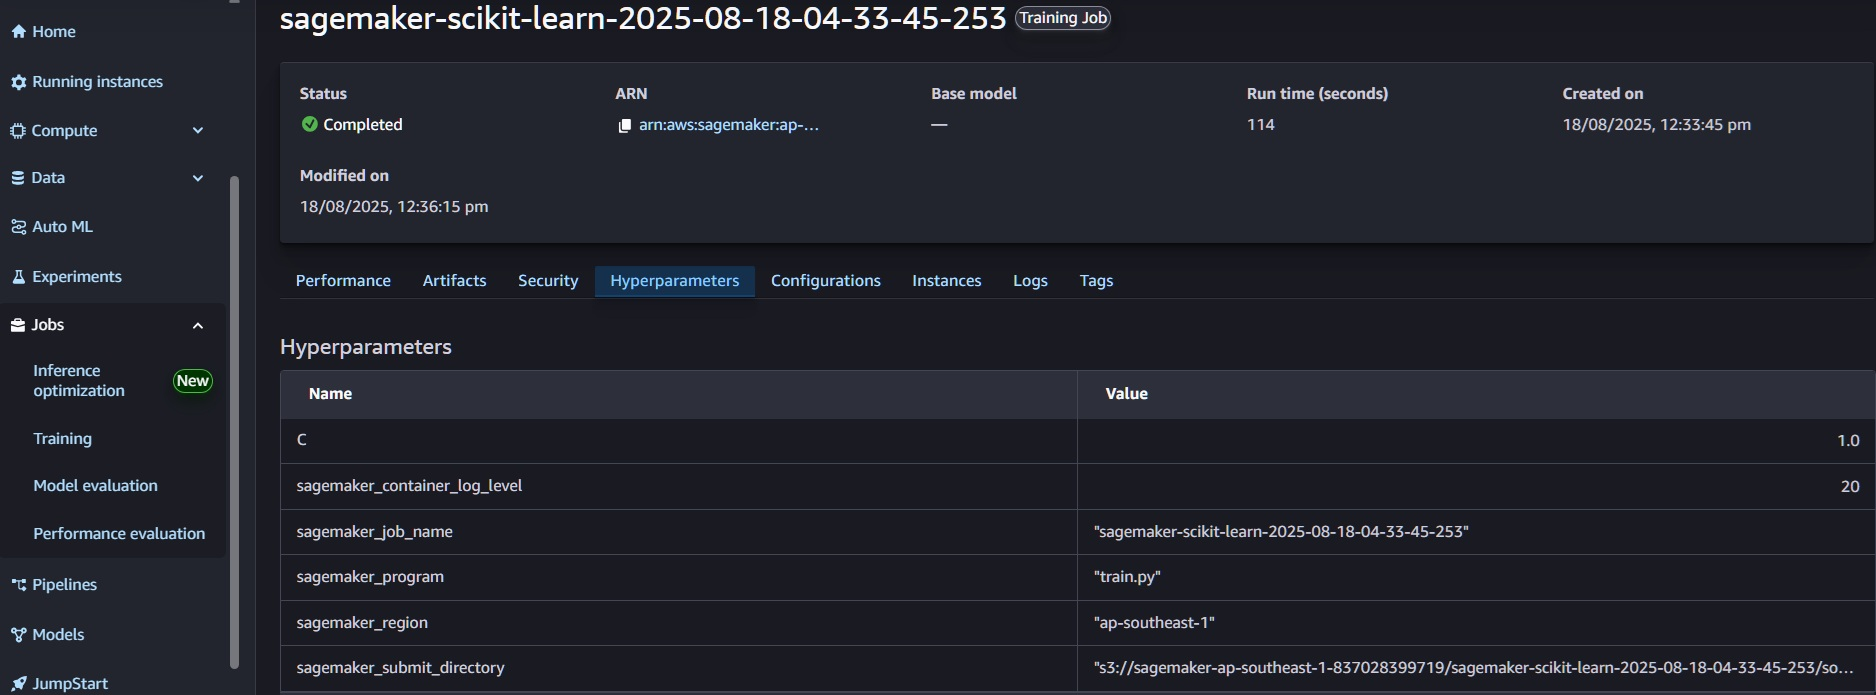

## 4) Evaluate with SKLearnProcessor → writes evaluation.json to S3

In [1]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
import time

# Create SKLearnProcessor for evaluation
# (this is used to run the evaluation script on the trained model)
ev = SKLearnProcessor(
    framework_version=SKLEARN_VERSION,  # same version used in training/serving
    role=role,
    instance_type="ml.t3.medium",
    instance_count=1,
    sagemaker_session=sess,
)

# Define the output path for evaluation results
# (this is where the evaluation results will be saved)
eval_out = EVAL_S3_BASE + f"run-{int(time.time())}/"

print("Using model artifact:", model_art)  # s3://.../output/model.tar.gz
ev.run(
    code="evaluate_sklearn.py",
    inputs=[
        ProcessingInput(source=model_art,       destination="/opt/ml/processing/model"),
        ProcessingInput(source=TEST_S3,         destination="/opt/ml/processing/test"),
    ],
    outputs=[
        ProcessingOutput(source="/opt/ml/processing/evaluation", destination=eval_out),
    ],
)

print("Evaluation JSON at:", eval_out + "evaluation.json")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│    5 # Create SKLearnProcessor for evaluation                                                    │
│    6 # (this is used to run the evaluation script on the trained model)                          │
│    7 ev = SKLearnProcessor(                                                                      │
│ ❱  8 │   framework_version=SKLEARN_VERSION,  # same version used in training/serving             │
│    9 │   role=role,                                                                              │
│   10 │   instance_type="ml.t3.medium",                                                           │
│   11 │   instance_count=1,                                                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'SKLEARN_VERSION' is not defined

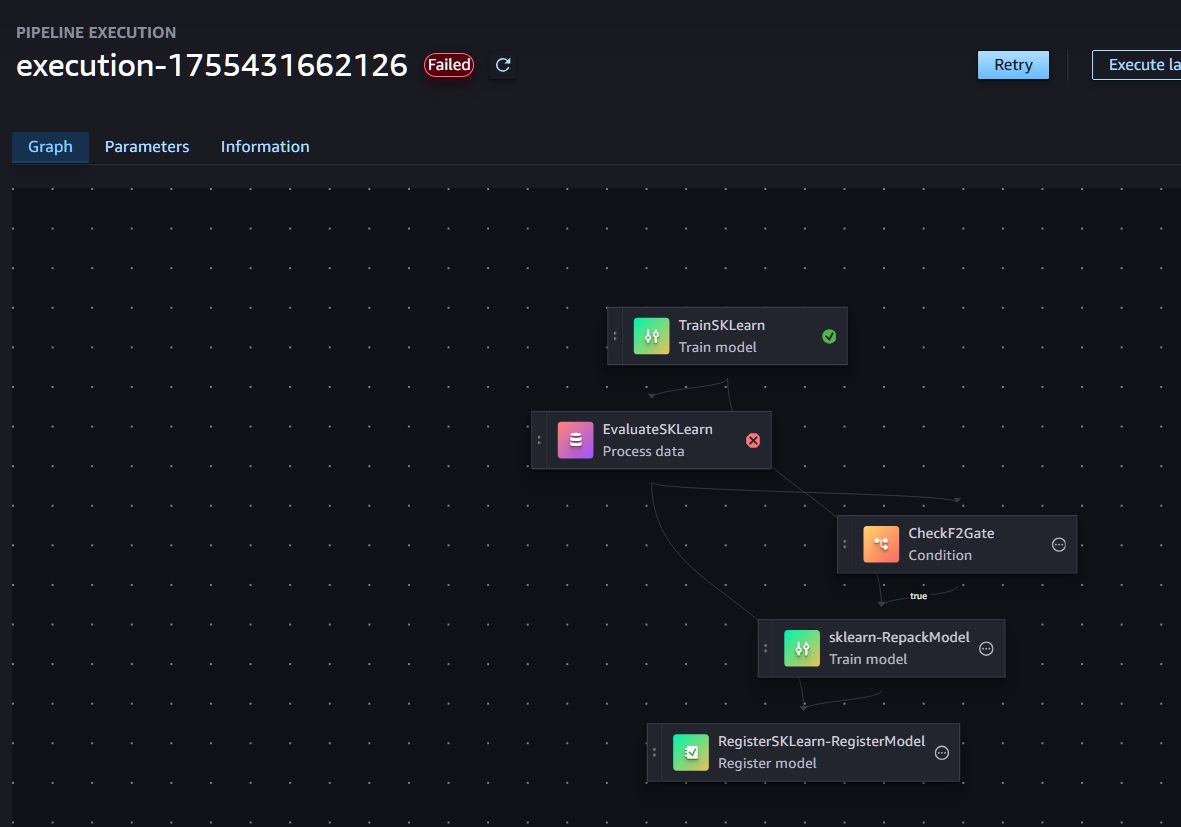

## Check latest JSON regristered

In [14]:
# Quick sanity check
resp = s3c.list_objects_v2(Bucket=BUCKET, Prefix=f"{PREFIX}/evaluation/")
cands = [o for o in resp.get("Contents", []) if o["Key"].endswith("evaluation.json")]
cands.sort(key=lambda x: x["LastModified"], reverse=True)
latest_eval = f"s3://{BUCKET}/{cands[0]['Key']}"
print("Latest eval json:", latest_eval)
print(json.loads(s3c.get_object(Bucket=BUCKET, Key=cands[0]["Key"])["Body"].read()))


Latest eval json: s3://sagemaker-ap-southeast-1-837028399719/ai4i/evaluation/run-1755495766/evaluation.json
{'metrics': {'precision': 1.0, 'recall': 1.0, 'f2': 1.0, 'auc': 1.0, 'pr_auc': 1.0000000000000002}, 'threshold': 0.5, 'sample_count': 1500, 'notes': {'loader': 'supports test.csv or X_test/y_test', 'model_source': 'model.joblib (extracted from model.tar.gz if needed)'}}


## 5) MLflow logging (simple & local; shows experimentation)

In [15]:
# MLflow logging (local file store; works in Studio)
import mlflow, mlflow.sklearn

# Set up MLflow tracking URI and experiment
# Note: This assumes you have MLflow installed and configured in your environment
mlflow.set_tracking_uri("file:/home/sagemaker-user/mlruns")
mlflow.set_experiment("ai4i")

# Log the model artifact and evaluation metrics
# Note: This assumes the model artifact and evaluation JSON are available
metrics = json.loads(s3c.get_object(Bucket=BUCKET, Key=cands[0]["Key"])["Body"].read())["metrics"]

# Log the run with parameters and metrics
with mlflow.start_run(run_name="ai4i-logistic"):
    mlflow.log_param("C", 1.0)
    mlflow.log_metric("f2",    metrics["f2"])
    mlflow.log_metric("auc",   metrics["auc"])
    mlflow.log_metric("pr_auc",metrics["pr_auc"])
    mlflow.log_metric("precision",metrics["precision"])
    mlflow.log_metric("recall",   metrics["recall"])
    # link the artifact & data locations for traceability
    mlflow.log_dict({"model_artifact": model_art, "eval_json": latest_eval}, "pointers.json")

print("Logged run to MLflow. In Studio: Open MLflow UI → Runs → verify F2.")


2025/08/18 06:54:50 INFO mlflow.tracking.fluent: Experiment with name 'ai4i' does not exist. Creating a new experiment.


Logged run to MLflow. In Studio: Open MLflow UI → Runs → verify F2.


## 6) Register model (attach metrics) → PendingManualApproval (governance)

In [16]:
# Register model to Model Registry (with metrics)
from sagemaker.sklearn.model import SKLearnModel
from sagemaker.model_metrics import MetricsSource, ModelMetrics

# prepare model metrics from evaluation.json
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=latest_eval,
        content_type="application/json"
    )
)

# Create SKLearnModel for registration
# Note: This assumes the inference.py and model artifact are available
sk_model = SKLearnModel(
    role=role,
    model_data=model_art,
    entry_point="inference.py",  # robust handler you wrote above
    framework_version=SKLEARN_VERSION,
    sagemaker_session=sess,
)

# Register the model to the Model Registry
# Note: This registers the model with content types, response types, and inference instances
pkg = sk_model.register(
    content_types=["application/json", "text/csv"],
    response_types=["application/json"],
    inference_instances=["ml.m5.large","ml.m5.xlarge"],
    transform_instances=["ml.m5.large"],
    model_package_group_name=MODEL_GROUP,
    approval_status="PendingManualApproval",
    description=f"Registered from {model_art} with F2={metrics['f2']:.3f}",
    model_metrics=model_metrics,
)

# Print the package ARN (Amazon Resource Name)
# This is the unique identifier for the registered model package
PKG_ARN = getattr(pkg, "model_package_arn", None) or str(pkg)
print("Package (pending):", PKG_ARN)


Package (pending): arn:aws:sagemaker:ap-southeast-1:837028399719:model-package/ai4i-predictive-maintenance/12


### Approve model
- or manual approval (Studio UI → Model Registry)

In [17]:
# Approve newest pending package
# find first pending and approve
resp = sm.list_model_packages(ModelPackageGroupName=MODEL_GROUP, SortBy="CreationTime", SortOrder="Descending")
pending = next((p for p in resp["ModelPackageSummaryList"] if p["ModelApprovalStatus"]=="PendingManualApproval"), None)
if not pending:
    print("No pending packages; using the latest Approved instead.")
else:
    sm.update_model_package(
        ModelPackageArn=pending["ModelPackageArn"],
        ModelApprovalStatus="Approved",
        ApprovalDescription="Approved for staging (meets F2 gate)."
    )
    print("Approved:", pending["ModelPackageArn"])


Approved: arn:aws:sagemaker:ap-southeast-1:837028399719:model-package/ai4i-predictive-maintenance/12


## Confirm you’re deploying the right package & image

In [19]:
import boto3, json, time, sagemaker
from sagemaker import image_uris

sess = sagemaker.Session()
sm   = boto3.client("sagemaker")
region = boto3.session.Session().region_name

MODEL_GROUP     = "ai4i-predictive-maintenance"   # <- keep your canonical name
ENDPOINT_NAME   = "ai4i-staging"                  # <- keep your canonical name
ENDPOINT_INSTANCE = "ml.m5.large"                 # safe default (or ml.c5.large)

# 1) Pick the latest Approved package (or lock to a version if you prefer)
resp = sm.list_model_packages(ModelPackageGroupName=MODEL_GROUP,
                              ModelApprovalStatus="Approved",
                              SortBy="CreationTime", SortOrder="Descending")
assert resp["ModelPackageSummaryList"], "No Approved packages found."
PKG_ARN = resp["ModelPackageSummaryList"][0]["ModelPackageArn"]
print("Approved package:", PKG_ARN)

# 2) Inspect the container image & model artifact used by this package
desc = sm.describe_model_package(ModelPackageName=PKG_ARN)
cont = desc["InferenceSpecification"]["Containers"][0]
print("Container image in package:", cont["Image"])
print("ModelDataUrl in package:", cont["ModelDataUrl"])

# 3) (Optional) What SKLearn serving image would SageMaker pick for your region/version?
#    If you trained with SKLearn 1.2-1, the serving image must be the same "1.2-1-cpu-py3".
sklearn_ref_image = image_uris.retrieve(framework="sklearn",
                                        region=region,
                                        version="1.2-1",
                                        image_scope="inference",
                                        instance_type=ENDPOINT_INSTANCE)
print("Expected SKLearn serving image (example 1.2-1):", sklearn_ref_image)


Approved package: arn:aws:sagemaker:ap-southeast-1:837028399719:model-package/ai4i-predictive-maintenance/12


INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


Container image in package: 121021644041.dkr.ecr.ap-southeast-1.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3
ModelDataUrl in package: s3://sagemaker-ap-southeast-1-837028399719/ai4i/models/sagemaker-scikit-learn-2025-08-18-04-33-45-253/output/model.tar.gz
Expected SKLearn serving image (example 1.2-1): 121021644041.dkr.ecr.ap-southeast-1.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3


## 7) Deploy latest Approved package → ai4i-staging

In [26]:
# -- Clean up anything stale, then deploy from the package's image+artifact, no env overrides --
import time
from botocore.exceptions import ClientError
from sagemaker.model import Model

image_uri   = c["Image"]
model_data  = c["ModelDataUrl"]
model_name  = f"{MODEL_GROUP}-{int(time.time())}"

# 0) Delete any endpoint + endpoint-config with the same name
try:
    sm.describe_endpoint(EndpointName=ENDPOINT_NAME)
    print("Deleting existing endpoint…")
    sm.delete_endpoint(EndpointName=ENDPOINT_NAME)
    while True:
        try:
            sm.describe_endpoint(EndpointName=ENDPOINT_NAME)
            time.sleep(8)
        except ClientError as e:
            if "Could not find" in str(e) or "does not exist" in str(e):
                break
            else:
                raise
    print("Endpoint deleted.")
except ClientError:
    pass

try:
    sm.describe_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
    print("Deleting old endpoint-config…")
    sm.delete_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
    time.sleep(3)
except ClientError:
    pass

# 1) Create a clean Model object (no Environment) using the package's image + model_data
mdl = Model(image_uri=image_uri, model_data=model_data, role=role, sagemaker_session=sess)

# 2) Deploy with generous timeouts
print(f"Deploying to '{ENDPOINT_NAME}' on {ENDPOINT_INSTANCE} …")
predictor = mdl.deploy(
    initial_instance_count=1,
    instance_type=ENDPOINT_INSTANCE,                     # try ml.c5.large if m5 still fails
    endpoint_name=ENDPOINT_NAME,
    model_data_download_timeout=1200,                    # seconds
    container_startup_health_check_timeout=600,          # seconds
)
print("Deployment call returned. Current status:",
      boto3.client("sagemaker").describe_endpoint(EndpointName=ENDPOINT_NAME)["EndpointStatus"])


Deleting existing endpoint…
Endpoint deleted.
Deleting old endpoint-config…


INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2025-08-18-09-43-52-241


Deploying to 'ai4i-staging' on ml.m5.large …


INFO:sagemaker:Creating endpoint-config with name ai4i-staging
INFO:sagemaker:Creating endpoint with name ai4i-staging


---------------------------*

ERROR:sagemaker:Please check the troubleshooting guide for common errors: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-troubleshooting.html#sagemaker-python-sdk-troubleshooting-create-endpoint


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:41                                                                                   │
│                                                                                                  │
│   38                                                                                             │
│   39 # 2) Deploy with generous timeouts                                                          │
│   40 print(f"Deploying to '{ENDPOINT_NAME}' on {ENDPOINT_INSTANCE} …")                           │
│ ❱ 41 predictor = mdl.deploy(                                                                     │
│   42 │   initial_instance_count=1,                                                               │
│   43 │   instance_type=ENDPOINT_INSTANCE,                     # try ml.c5.large if m5 still f    │
│   44 │   endpoint_name=ENDPOINT_NAME,                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/model.py:1814 in deploy                        │
│                                                                                                  │
│   1811 │   │   │   │   )                                                                         │
│   1812 │   │   │   │   self.sagemaker_session.update_endpoint(self.endpoint_name, endpoint_conf  │
│   1813 │   │   │   else:                                                                         │
│ ❱ 1814 │   │   │   │   self.sagemaker_session.endpoint_from_production_variants(                 │
│   1815 │   │   │   │   │   name=self.endpoint_name,                                              │
│   1816 │   │   │   │   │   production_variants=[production_variant],                             │
│   1817 │   │   │   │   │   tags=tags,                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/session.py:6033 in                             │
│ endpoint_from_production_variants                                                                │
│                                                                                                  │
│   6030 │   │   logger.info("Creating endpoint-config with name %s", name)                        │
│   6031 │   │   self.sagemaker_client.create_endpoint_config(**config_options)                    │
│   6032 │   │                                                                                     │
│ ❱ 6033 │   │   return self.create_endpoint(                                                      │
│   6034 │   │   │   endpoint_name=name,                                                           │
│   6035 │   │   │   config_name=name,                                                             │
│   6036 │   │   │   tags=endpoint_tags,                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/session.py:4878 in create_endpoint             │
│                                                                                                  │
│   4875 │   │   │   logger.error(                                                                 │
│   4876 │   │   │   │   "Please check the troubleshooting guide for common errors: %s", troubles  │
│   4877 │   │   │   )                                                                             │
│ ❱ 4878 │   │   │   raise e                                                                       │
│   4879 │                                                                                         │
│   4880 │   def endpoint_in_service_or_not(self, endpoint_na

## 8) Smoke test (both JSON & CSV)

In [ ]:
# Smoke test (JSON & CSV)
rt = boto3.client("sagemaker-runtime")

# pick one clean row from processed test (works for csv or parquet)
# try CSV first
def pick_clean_row():
    # list CSVs under processed/test
    resp = s3c.list_objects_v2(Bucket=BUCKET, Prefix=f"{PREFIX}/processed/test/")
    keys = [o["Key"] for o in resp.get("Contents", []) if o["Key"].endswith(".csv")]
    if not keys: raise RuntimeError("No test CSV under processed/test/")
    obj = s3c.get_object(Bucket=BUCKET, Key=keys[0])
    df = pd.read_csv(io.BytesIO(obj["Body"].read()))
    if TARGET in df.columns:
        feats = [c for c in df.columns if c != TARGET]
        return df[feats].dropna().iloc[0], feats
    else:
        return df.dropna().iloc[0], list(df.columns)

row, feat_cols = pick_clean_row()

# JSON request
payload = {"instances":[row.to_dict()]}
r = rt.invoke_endpoint(
    EndpointName=ENDPOINT_NAME,
    ContentType="application/json",
    Body=json.dumps(payload),
)
print("JSON →", r["Body"].read().decode())

# CSV request (same order as training features; handler will align if needed)
csv_line = ",".join(str(row[c]) for c in feat_cols)
r = rt.invoke_endpoint(
    EndpointName=ENDPOINT_NAME,
    ContentType="text/csv",
    Body=csv_line,
)
print("CSV  →", r["Body"].read().decode())


## 9) Cleanup Endpoint (Optional)


In [27]:
# NOTE: will delete the endpoint to stop charges
import boto3
sm = boto3.client("sagemaker")
sm.delete_endpoint(EndpointName=endpoint_name)
print("Endpoint deleted")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # NOTE: will delete the endpoint to stop charges                                             │
│   2 import boto3                                                                                 │
│   3 sm = boto3.client("sagemaker")                                                               │
│ ❱ 4 sm.delete_endpoint(EndpointName=endpoint_name)                                               │
│   5 print("Endpoint deleted")                                                                    │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'endpoint_name' is not defined